# Subject Line Generation 

## Pacakges

In [2]:
import numpy as np
import pandas as pd
import transformers
# import tensorflow as tf
import os

In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data 

In [4]:
ROOT = '/home/mluser/users'
data_subjects = os.path.join(ROOT, 'data', 'subject_line')
print(data_subjects)

/home/mluser/users/data/subject_line


In [5]:
result = []
for (r, d, f) in os.walk(data_subjects):
    df = pd.read_parquet(os.path.join(r, f[15]))
    print(len(f))
#     for i in f:
#         result.append(pd.read_parquet(os.path.join(r, i)))

30


In [6]:
data = list(set(df['subject'].dropna()))

In [7]:
len(data)

135047

In [8]:
final = []
for d in data:
    k = [l for l in d if l=="{" or l=="}" or l=="[" or l=="]" or l=="(" or l==")"]
    if len(k)<4:
        if "Lewisville" not in d:
            final.append(d)
data = final

In [9]:
MAX_LENGTH = 20

def filterSubject(p):
    return len(p.split(' ')) < MAX_LENGTH

def filterSubjects(subs):
    return [sub for sub in subs if filterSubject(sub)]

In [10]:
print(len(data))
data = filterSubjects(data)

93660


In [11]:
def normalizeString(s):
    s = s.lower().strip()
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [12]:
data = [normalizeString(d) for d in data]

In [69]:
len(data)

87823

## Install Glove word embeddings

In [5]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-02-03 21:45:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-02-03 21:45:23--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-02-03 21:45:23--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

100%[==

In [6]:
# !unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


## Training Data

### Gensim Embeddings + Euclidean

#### Text Preprocessing

In [70]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [71]:
import nltk
t = []
for i in data:
    t.append(w2v_tokenize_text(i))

#### Glove Word Embeddings

In [72]:
import os
import numpy as np

# Create Empty dictionary
word2vector = {}

#Create a dictionary with word and corresponding vector
with open(os.path.join('./glove.6B/glove.6B.300d.txt')) as file:
  
  for line in file:
    list_of_values = line.split()    	
    word = list_of_values[0]
    vector_of_word = np.asarray(list_of_values[1:], dtype='float32')
    word2vector[word] = vector_of_word

msg = f"Total number of words and corresponding vectors in word2vectors are {len(word2vector)}"
print(msg)

Total number of words and corresponding vectors in word2vectors are 400000


In [74]:
import gensim
def wordprint(words,wv):
    all_words, mean = set(), []
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.keys():
           a = np.array(wv.loc[word])
           mean.append(a)
    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(300,)   
    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean    

def getMeanEmbeddings(subject, w2v):
    mean = []
    count = 0
    for word in subject:
        if word in w2v.keys():
            mean.append(w2v[word])
            count+=1
#         else:
#             print(word, ' not in vocabulary.')
    if count>0:
        mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
        return mean
    else:
        return np.zeros(300,)

def  word_averaging_listn(w2v, subjects):
    return np.vstack([getMeanEmbeddings(subject, w2v) for subject in subjects ])

In [77]:
avg_embeddings=word_averaging_listn(word2vector, t)

In [78]:
avg_embeddings.shape

(87823, 300)

In [79]:
data[90], embeddings[90]

('consultez l activit de votre compte paypal',
 array([ 4.3665e-01,  1.8793e-01, -1.7022e-01, -1.0869e-01,  1.9476e-01,
        -2.4502e-01, -7.7660e-01, -2.5813e-01,  4.3630e-01, -2.0884e+00,
        -9.6794e-03,  1.4941e-01,  7.2166e-02, -6.5154e-01, -3.0189e-01,
         8.5747e-01, -3.1906e-02, -4.5204e-01,  8.4932e-02, -4.1816e-01,
         2.6820e-01, -4.5985e-02,  8.0586e-01, -1.3507e-01, -4.7616e-01,
         1.4891e-01,  2.3255e-01,  3.2640e-01,  2.1525e-01, -4.9949e-01,
         4.6968e-01,  1.5521e-01,  4.8574e-01,  3.3412e-01, -1.4695e+00,
         6.2657e-02,  1.9865e-01, -2.9627e-01, -3.4174e-02, -3.9326e-01,
         4.5055e-02,  2.7545e-01, -2.3320e-01, -4.9622e-02, -3.3297e-01,
        -4.0912e-01, -2.4932e-01, -3.8237e-01,  8.8357e-02, -3.8397e-01,
        -2.0878e-01,  1.2368e-03,  3.4651e-01,  1.0924e+00,  5.1525e-01,
         2.9204e-01, -2.0349e-01,  4.0670e-01,  7.7727e-01, -7.7313e-02,
        -2.3235e-02,  1.2527e-01,  4.2712e-01, -2.3133e-01,  4.2311e-01,
    

# Subject 10

## Euclidean Distance between Embeddings

In [31]:
embeddings = list(word2vector.values())

In [88]:
def get_top_ind_eu(num, top):
    dist = {}
    for (i,d) in enumerate(avg_embeddings):
        dist[i] =  np.linalg.norm(d-avg_embeddings[num])
    dist = dict(sorted(dist.items(),key= lambda x:x[1]))
    return list(dist.keys())[:top]

In [89]:
def get_top_subj_eu(d, ind, top, printOutput=False):
    out = [d[i] for i in get_top_ind_eu(ind,top)]
    if printOutput:
        print('Input Subject: ', d[ind], '\n')
        for o in out:
            print('Output Subject: ', o)
    return out

In [82]:
get_top_subj_eu(data, 150, 10, True)

Input Subject:  could once a day be the appropriate choice ? 

Output Subject:  could once a day be the appropriate choice ?
Output Subject:  now this is serious spring saving
Output Subject:  beste aussichten fu r ihren online shop mit paypal plus
Output Subject:  who st . patrick really was ireland s most enchanting castle and why ireland is snakeless
Output Subject:  testing click heat map please click around the header footer and main 
Output Subject:  summary report hold notice cie 
Output Subject:   banggood victoria s secret gymboree .
Output Subject:   preseason is here grab a win in this week s fantasy slate contest !
Output Subject:  because we truly appreciate your business
Output Subject:  hasta un m s de ventas con las herramientas de paypal


['could once a day be the appropriate choice ?',
 'now this is serious spring saving',
 'beste aussichten fu r ihren online shop mit paypal plus',
 'who st . patrick really was ireland s most enchanting castle and why ireland is snakeless',
 'testing click heat map please click around the header footer and main ',
 'summary report hold notice cie ',
 ' banggood victoria s secret gymboree .',
 ' preseason is here grab a win in this week s fantasy slate contest !',
 'because we truly appreciate your business',
 'hasta un m s de ventas con las herramientas de paypal']

## Training and Testing data

In [153]:
from tqdm import tqdm

def prepareData(data, word2vec, top_k=5, subLen=1000):
    print("Read %s subject lines" % len(data))    
    clean_subjects = data
    word2vec['EOS'] = np.zeros((300,))
    word2vec['SOS'] = np.zeros((300,))
    for i in tqdm(clean_subjects):
        for word in i.split(' '):
            if word not in word2vec.keys():
                word2vec[word] = np.zeros((300,))
    print("Trimmed to %s subjects" % len(clean_subjects))
    
    embeddings = list(word2vec.values())    
    print("Generating Similar subject lines...")
    output_subjects = []
    for i, clean_subject in enumerate(tqdm(clean_subjects)):
        if i<subLen:
            output = get_top_subj_eu(clean_subjects, i, top_k)  
            output_subjects.append(output)
        
    print("Saved input-output data")
    
    return clean_subjects, output_subjects, word2vec

In [85]:
len(data)

87823

In [90]:
input_subjects, output_subjects, word2vec = prepareData(data, word2vector,5, 1000)

Read 87823 subject lines


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 87823/87823 [00:00<00:00, 466022.58it/s]


Trimmed to 87823 subjects
Generating Similar subject lines...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 87823/87823 [12:02<00:00, 121.48it/s]

Saved input-output data


In [ ]:
print(random.choice(input_subjects))
print(random.choice(output_subjects))

# Autoencoder + Decoder Models

## Model

In [176]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, matrix_embeddings):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding.from_pretrained(matrix_embeddings)
        self.embedding.requires_grad = False
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        embedded = embedded.view(1,1,-1)
        output = embedded.float()
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [177]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, matrix_embeddings):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding.from_pretrained(matrix_embeddings)
#         .view(1, 1, -1)
        self.embedding.requires_grad = False
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        # .view(1, 1, -1)
        print(embedded.shape)
        embedded = embedded.view(1,1,-1).float()
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [178]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, matrix_embeddings, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding.from_pretrained(matrix_embeddings)
        self.embedding.requires_grad = False
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input)
        # .view(1, 1, -1)
        embedded = embedded.view(1,1,-1).float()
        embedded = self.dropout(embedded)
#         print('Decoder Embedded after reshape: ', embedded.shape)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), 
            dim=1
        )
#         print(attn_weights.shape)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0)
                                )
#         print(attn_applied.shape)

        output = torch.cat((embedded[0], attn_applied[0]), 1)
#         print(output.shape)
        output = self.attn_combine(output).unsqueeze(0)
#         print(output.shape)

        output = F.relu(output)
#         print(output.shape)
        output, hidden = self.gru(output, hidden)
#         print(output.shape, hidden.shape)

        output = F.log_softmax(self.out(output[0]), dim=1)
#         print('Decoder - Outputs: ', output.shape, ' Hidden: ', hidden.shape, ' Attn. Weights: ', attn_weights.shape)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Training

### Autoencoder Training

#### Preprocessing

In [93]:
word2vec['life'].shape

(300,)

In [94]:
words = []
embedded = []
for i, (word, vector) in enumerate(word2vec.items()):
    words.append(word)
    embedded.append(vector)

In [95]:
EOS_token = words.index('EOS')
EOS_token

400000

In [96]:
len(words[400000:])
# words[400000:]

11033

In [264]:
w_n, e_n = np.array(words), np.array(embedded)

In [ ]:
w_n.tofile( 'words.csv',  sep = ',')
e_n.tofile( 'embedded.csv',  sep = ',')

In [119]:
## Customized
def indexesFromSentence(sentence):
    temp = []
    for word in sentence.split(' '):
        temp.append(words.index(word))
    return temp

def tensorFromSentence(sentence):
    indexes = indexesFromSentence(sentence)
    indexes.append(words.index('EOS'))
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromSubsTar1(input_subject, k=0):
    input_tensor = tensorFromSentence(input_subject)
    i = input_subjects.index(input_subject)
    target_tensors= tensorFromSentence(output_subjects[i][k])
    return (input_tensor, target_tensors)

def tensorsFromInSub(input_subject):
    input_tensor = tensorFromSentence(input_subject)
    return (input_tensor, input_tensor)

### Encoder

In [179]:
# Original
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    # Encoder Training
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Decoder Training
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(1,target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [180]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [181]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [182]:
## Original
def trainIters(encoder, decoder, words, n_iters, print_every=1000, plot_every=100, learning_rate=0.01, k=0):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = []
    for i in tqdm(range(n_iters)):
        inp = random.choice(input_subjects[:1000])
        while len(inp)>20:
            inp = random.choice(input_subjects[:1000])
        training_pairs.append(tensorsFromInSub(inp))
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### Training-1

In [183]:
hidden_size = 300
k=1
EOS_token = words.index('EOS')
SOS_token = words.index('SOS')
input_size = len(words)
encoder1 = EncoderRNN(input_size, hidden_size, torch.tensor(np.array(embedded))).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, input_size, torch.tensor(np.array(embedded)), dropout_p=0.1).to(device)
# decoder1 = DecoderRNN(hidden_size, input_sub.n_words).to(device)

In [185]:
trainIters(encoder1, attn_decoder1, words, 100, print_every=10, plot_every=10, k=k)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 67.09it/s]


0m 5s (- 0m 52s) (10 10%) 3.4356
0m 10s (- 0m 41s) (20 20%) 4.2649
0m 14s (- 0m 34s) (30 30%) 3.3673
0m 20s (- 0m 31s) (40 40%) 3.1730
0m 25s (- 0m 25s) (50 50%) 3.3001
0m 31s (- 0m 20s) (60 60%) 4.0578
0m 36s (- 0m 15s) (70 70%) 3.8319
0m 40s (- 0m 10s) (80 80%) 3.3825
0m 46s (- 0m 5s) (90 90%) 4.7980
0m 51s (- 0m 0s) (100 100%) 3.5222


In [186]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[words.index(sentence[1])]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(words[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [187]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        inp = random.choice(input_subjects[:1000])
        
        pair = (inp, inp)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [188]:
evaluateRandomly(encoder1, attn_decoder1)

> there s still time for up to off !
= there s still time for up to off !
< paypal paypal paypal <EOS>

> best way to use your points january s new rewards
= best way to use your points january s new rewards
< paypal paypal paypal paypal <EOS>

> thank you for staying with us but you are missing out on rewards !
= thank you for staying with us but you are missing out on rewards !
< paypal paypal paypal paypal <EOS>

> save over on centrum and other brands you trust .
= save over on centrum and other brands you trust .
< paypal paypal paypal paypal <EOS>

> notice of important account update
= notice of important account update
< paypal paypal paypal paypal <EOS>

> summary report wealth management letter c client list
= summary report wealth management letter c client list
< paypal paypal paypal paypal <EOS>

> preparations for your next financial steps
= preparations for your next financial steps
< paypal paypal paypal <EOS>

> start the new year off with huge savings !
= start the ne

In [173]:
evaluateRandomly(encoder1, attn_decoder1)

>  cj 
=  cj 
<  <EOS>

> trans alps f .k .t . ii utmb schuh
= trans alps f .k .t . ii utmb schuh
<   <EOS>

> testing pros yahoo fix
= testing pros yahoo fix
<  a <EOS>

> welcome ! save with your card today !
= welcome ! save with your card today !
< a ! ! ! <EOS>

> lendingspace reprice issue
= lendingspace reprice issue
<  <EOS>

> this hair saver just landed and everyone s obsessed
= this hair saver just landed and everyone s obsessed
< a ! ! <EOS>

>  son gunler eksta i ndirim ve ampuan hediyenizi ka rmay n !
=  son gunler eksta i ndirim ve ampuan hediyenizi ka rmay n !
< ! ! ! <EOS>

> this week s hunt deals bogo off winchester usa ammo !
= this week s hunt deals bogo off winchester usa ammo !
< ! ! ! <EOS>

> let dealer name ?trim put winter in your rearview mirror
= let dealer name ?trim put winter in your rearview mirror
< a a ! <EOS>

> black friday ist jetzt ! bis rabatt
= black friday ist jetzt ! bis rabatt
<  ! ! <EOS>



In [174]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, data[10])
plt.matshow(attentions.numpy())

In [150]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

In [151]:
evaluateAndShowAttention(data[10])
evaluateAndShowAttention(data[244])
evaluateAndShowAttention(data[345])
evaluateAndShowAttention(data[543])

input =  paypal 
output =    <EOS>


/tmp/ipykernel_3097/3159908345.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_3097/3159908345.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


input = we know this is your favorite special offer . . . .
output = off th th th <EOS>
input =  march petronas picks agency for btl duties public trust in boeing remains in question
output = paypal    <EOS>
input = send money directly to bank accounts abroad !
output = paypal    <EOS>


### Decoder Training

In [276]:
# Original

teacher_forcing_ratio = 0.5

def trainDecoder(input_tensor, target_tensor, encoder, decoder, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    decoder_optimizer.step()

    return loss.item() / target_length

In [280]:
## Original
def trainItersDecoder(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01, k=0):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = []
    for i in range(n_iters):
        inp = random.choice(input_subjects[:1000])
        while len(inp)>20:
            inp = random.choice(input_subjects[:1000])
        training_pairs.append(tensorsFromSubsTar1(inp, k))
    criterion = nn.NLLLoss()

    for iter in tqdm(range(1, n_iters + 1)):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = trainDecoder(input_tensor, target_tensor, encoder,
                     decoder, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [281]:
hidden_size = 256
k=1
attn_decoder = [ AttnDecoderRNN(hidden_size, output_sub[i].n_words, dropout_p=0.1).to(device) 
                for i in range(5) ]
# decoder1 = DecoderRNN(hidden_size, input_sub.n_words).to(device)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.46it/s]


0m 16s (- 0m 0s) (1000 100%) 1.6988


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 77.92it/s]


0m 12s (- 0m 0s) (1000 100%) 1.6652


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 58.98it/s]


0m 17s (- 0m 0s) (1000 100%) 1.7846


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 54.39it/s]


0m 18s (- 0m 0s) (1000 100%) 1.8099


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 62.54it/s]

0m 16s (- 0m 0s) (1000 100%) 1.7547


<Figure size 432x288 with 0 Axes>

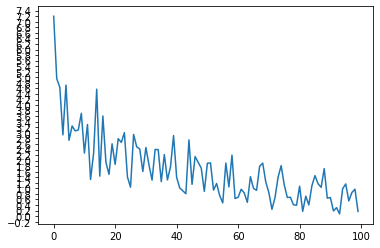

<Figure size 432x288 with 0 Axes>

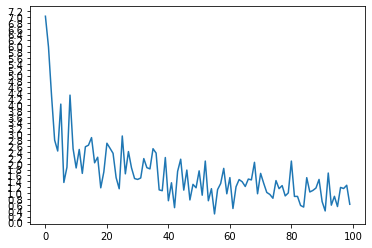

<Figure size 432x288 with 0 Axes>

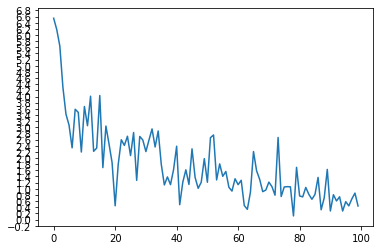

<Figure size 432x288 with 0 Axes>

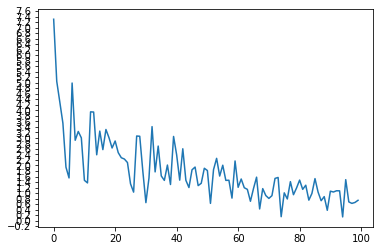

<Figure size 432x288 with 0 Axes>

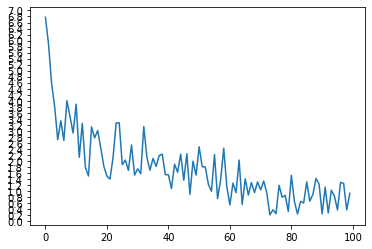

In [282]:
for i in range(5):
    trainItersDecoder(encoder1, attn_decoder[i], 1000, print_every=1000, plot_every=10, k=i)

In [283]:
def evaluateDecoder(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_sub, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(input_sub.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [286]:
def evaluateRandomlyDecoder(encoder, decoder, k=0):
    for i in range(n):
        inp = random.choice(input_subjects[:1000])
        ind = input_subjects.index(inp)
        out = output_subjects[ind][k]
        pair = (inp, out)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluateDecoder(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [306]:
for i in range(5):
    print('\n\nPart ', i, '\n')
    evaluateRandomly(encoder1, attn_decoder[i])



Part  0 

> get to know your new essential portfolio
= get to know your new essential portfolio
< summary report rs rollover ira acceptance service  <EOS>

> tips to help your gassy . month old .
= tips to help your gassy . month old .
< success scott off com limited <EOS>

> time to shop ! to off almost everything online earn place ca h !
= time to shop ! to off almost everything online earn place ca h !
< summary report rs rollover ira acceptance service  <EOS>

> enjoy these money saving service specials
= enjoy these money saving service specials
< summary report rs rollover ira acceptance service  <EOS>

> come along to our next wedding fayre and find out how you could win your wedding !
= come along to our next wedding fayre and find out how you could win your wedding !
< summary report rs rollover ira acceptance service  <EOS>

> handpicked black friday offers just for you .
= handpicked black friday offers just for you .
< success scott off com limited <EOS>

> box office mad

In [287]:
for i in range(5):
    print('\n\nPart ', i, '\n')
    evaluateRandomly(encoder1, attn_decoder[i])



Part  0 

> news and events from newcastle marriott hotel gosforth park
= news and events from newcastle marriott hotel gosforth park
< summary report rs rollover ira acceptance service  <EOS>

> it s possible to manage your condition
= it s possible to manage your condition
< summary report rs rollover ira acceptance service  <EOS>

> watchdog week attorney seeks criminal investigation into edison s handling of nuclear waste at san onofre
= watchdog week attorney seeks criminal investigation into edison s handling of nuclear waste at san onofre
< summary report rs rollover ira acceptance service  <EOS>

> offers in beverly hills approval 
= offers in beverly hills approval 
< summary report rs rollover ira acceptance service  <EOS>

> get special early access to our super weekend sale !
= get special early access to our super weekend sale !
< summary report rs rollover ira acceptance service  <EOS>

> new features to help you stay connected .
= new features to help you stay connecte

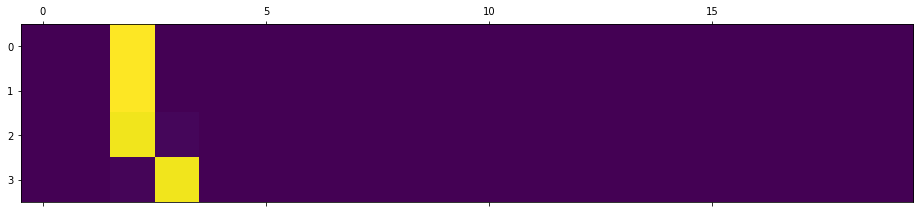

In [273]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, data[10])
plt.matshow(attentions.numpy())

In [274]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

input = summary report new coupon template 
output =  today only <EOS>
input = test jm military dtv 
output = keep fresh in style  <EOS>
input = celebrate a magical moment with a star map from the night sky
output = connecting the dots <EOS>
input = willkommen zur ck mit exklusiven angeboten f r
output = connecting the dots <EOS>


/tmp/ipykernel_31400/3159908345.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_31400/3159908345.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


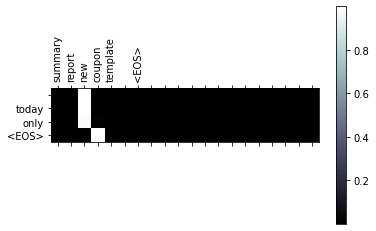

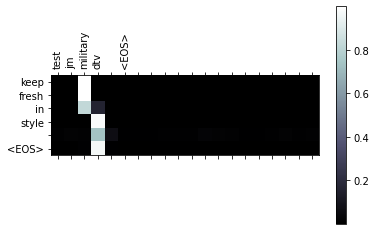

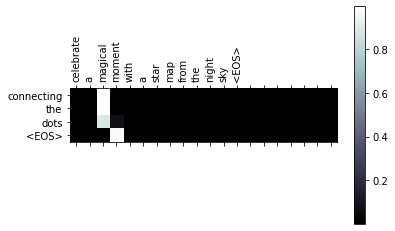

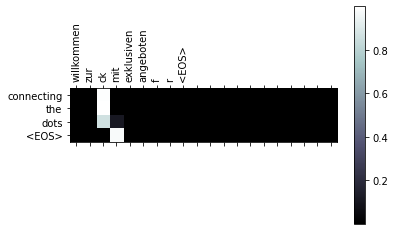

In [275]:
evaluateAndShowAttention(data[10])
evaluateAndShowAttention(data[244])
evaluateAndShowAttention(data[345])
evaluateAndShowAttention(data[543])

## Save Models

In [288]:
import pickle

In [294]:
f = open('encoder','wb')
pickle.dump(encoder1,f)
f.close()
f = open('decoder','wb')
pickle.dump(attn_decoder, f)
f.close()

In [298]:
f = open('encoder','rb')
e = pickle.load(f)
f.close()

In [299]:
d

[AttnDecoderRNN(
   (embedding): Embedding(2370, 256)
   (attn): Linear(in_features=512, out_features=20, bias=True)
   (attn_combine): Linear(in_features=512, out_features=256, bias=True)
   (dropout): Dropout(p=0.1, inplace=False)
   (gru): GRU(256, 256)
   (out): Linear(in_features=256, out_features=2370, bias=True)
 ),
 AttnDecoderRNN(
   (embedding): Embedding(2194, 256)
   (attn): Linear(in_features=512, out_features=20, bias=True)
   (attn_combine): Linear(in_features=512, out_features=256, bias=True)
   (dropout): Dropout(p=0.1, inplace=False)
   (gru): GRU(256, 256)
   (out): Linear(in_features=256, out_features=2194, bias=True)
 ),
 AttnDecoderRNN(
   (embedding): Embedding(2135, 256)
   (attn): Linear(in_features=512, out_features=20, bias=True)
   (attn_combine): Linear(in_features=512, out_features=256, bias=True)
   (dropout): Dropout(p=0.1, inplace=False)
   (gru): GRU(256, 256)
   (out): Linear(in_features=256, out_features=2135, bias=True)
 ),
 AttnDecoderRNN(
   (embe

In [297]:
f = open('decoder','rb')
d = pickle.load(f)
f.close()